In [1]:
#importing the necessary libraries 
import pandas as pd 
import sqlite3
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [21]:
# making connection to the database 
conn=  sqlite3.connect("../Data/bootcamp_db")
conn

In [22]:
sql_query = """SELECT name 
                FROM sqlite_master 
                where type = 'table';"""

In [23]:
cursor = conn.cursor()
cursor.execute(sql_query)
print(f"list of tables in the database:\n{cursor.fetchall()}")

list of tables in the database:
[('online_transactions',), ('stock_description',), ('online_transactions_cleaned',)]


In [24]:
query=""" select * 
         from online_transactions_cleaned"""

In [25]:
ot_transactions=pd.read_sql(query,conn)

In [26]:
ot_transactions

,invoice,stock_code,description,total_cost,invoice_date,price,quantity,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,30.00,2010-12-01 08:45:00,1.25,24,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,15.30,2010-12-01 09:02:00,2.55,6,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,19.50,2010-12-01 09:37:00,1.95,10,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,2010-12-01 09:41:00,2.95,1,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,11.90,2010-12-01 09:41:00,5.95,2,u15311,United Kingdom
...,...,...,...,...,...,...,...,...,...
399836,581580,22698,PINK REGENCY TEACUP AND SAUCER,2.95,2011-12-09 12:20:00,2.95,1,u12748,United Kingdom
399837,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,51.84,2011-12-09 12:25:00,0.72,72,u13777,United Kingdom
399838,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,23.40,2011-12-09 12:31:00,1.95,12,u15804,United Kingdom
399839,581585,84692,BOX OF 24 COCKTAIL PARASOLS,10.50,2011-12-09 12:31:00,0.42,25,u15804,United Kingdom


# Preprocessing Data for Segmentation
The informative features in this dataset that tell us about customer buying behavior include “quantity”, “invoice_date” and “total_cost” Using these variables, we are going to derive a customer’s RFM profile - Recency, Frequency, Monetary Value.

RFM is commonly used in marketing to evaluate a client’s value based on their:
Recency (R): How recently did a particular customer make a purchase?
Frequency (F): How often do they make purchases?
Monetary Value (M): How much money do they spend?

We’ll use the information in the dataset to compute the recency, frequency, and monetary values. Then, we’ll map these values to the generally used RFM score scale of 1 - 5. 

we’ll try to identify customer segments with similar RFM characteristics. And for this, we’ll use K-Means clustering, an unsupervised machine learning algorithm that groups similar data points into clusters.

In [27]:
ot_transactions.head()

,invoice,stock_code,description,total_cost,invoice_date,price,quantity,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,30.00,2010-12-01 08:45:00,1.25,24,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,15.30,2010-12-01 09:02:00,2.55,6,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,19.50,2010-12-01 09:37:00,1.95,10,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,2010-12-01 09:41:00,2.95,1,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,11.90,2010-12-01 09:41:00,5.95,2,u15311,United Kingdom


In [29]:
ot_transactions.describe()

,total_cost,price,quantity
count,399841.000000,399841.000000,399841.000000
mean,20.716904,2.952914,12.224359
std,425.471765,7.317593,250.788860
min,-168469.600000,0.000000,-80995.000000
25%,4.250000,1.250000,2.000000
50%,11.580000,1.950000,5.000000
75%,19.500000,3.750000,12.000000
max,168469.600000,1599.260000,80995.000000


The “Quantity” and “total_cost” columns contain negative values:

In [10]:
ot_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399841 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   invoice       399841 non-null  object 
 1   stock_code    399841 non-null  object 
 2   description   399841 non-null  object 
 3   total_cost    399841 non-null  float64
 4   invoice_date  399841 non-null  object 
 5   price         399841 non-null  float64
 6   quantity      399841 non-null  int64  
 7   customer_id   399841 non-null  object 
 8   country       399841 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 27.5+ MB


The data has no missing values. But they contain negative values. So let's also drop the records with negative values for  “quantity” and “total_cost”:

In [30]:
# Remove rows with negative Quantity and Price
ot_transactions = ot_transactions[(ot_transactions['quantity'] > 0) & (ot_transactions['total_cost'] > 0)]

In [31]:
ot_transactions.reset_index(drop=True)

,invoice,stock_code,description,total_cost,invoice_date,price,quantity,customer_id,country
0,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,30.00,2010-12-01 08:45:00,1.25,24,u12583,France
1,536373,82494L,WOODEN FRAME ANTIQUE WHITE,15.30,2010-12-01 09:02:00,2.55,6,u1785,United Kingdom
2,536378,21929,JUMBO BAG PINK VINTAGE PAISLEY,19.50,2010-12-01 09:37:00,1.95,10,u14688,United Kingdom
3,536381,37444A,YELLOW BREAKFAST CUP AND SAUCER,2.95,2010-12-01 09:41:00,2.95,1,u15311,United Kingdom
4,536381,15056BL,EDWARDIAN PARASOL BLACK,11.90,2010-12-01 09:41:00,5.95,2,u15311,United Kingdom
...,...,...,...,...,...,...,...,...,...
391295,581580,22698,PINK REGENCY TEACUP AND SAUCER,2.95,2011-12-09 12:20:00,2.95,1,u12748,United Kingdom
391296,581584,20832,RED FLOCK LOVE HEART PHOTO FRAME,51.84,2011-12-09 12:25:00,0.72,72,u13777,United Kingdom
391297,581585,22178,VICTORIAN GLASS HANGING T-LIGHT,23.40,2011-12-09 12:31:00,1.95,12,u15804,United Kingdom
391298,581585,84692,BOX OF 24 COCKTAIL PARASOLS,10.50,2011-12-09 12:31:00,0.42,25,u15804,United Kingdom


In [32]:
ot_transactions['invoice_date']=pd.to_datetime(ot_transactions['invoice_date'])

C:\Users\dines\AppData\Local\Temp\ipykernel_22868\170961715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ot_transactions['invoice_date']=pd.to_datetime(ot_transactions['invoice_date'])


In [33]:
ot_transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391300 entries, 0 to 399840
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   invoice       391300 non-null  object        
 1   stock_code    391300 non-null  object        
 2   description   391300 non-null  object        
 3   total_cost    391300 non-null  float64       
 4   invoice_date  391300 non-null  datetime64[ns]
 5   price         391300 non-null  float64       
 6   quantity      391300 non-null  int64         
 7   customer_id   391300 non-null  object        
 8   country       391300 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 29.9+ MB


Compute Recency, Frequency, and Monetary Value

In [35]:
# defining a reference date 'snapshot_date' that’s a day later than the most recent date in the “invoice_date” column:

snapshot_date = max(ot_transactions['invoice_date']) + pd.DateOffset(days=1)

1.For recency, we’ll calculate the difference between the most recent purchase date and a reference date (snapshot_date). This gives the number of days since the customer's last purchase. 

2.For frequency measures how often a customer makes purchases, we’ll calculate it as the total number of unique invoices or transactions made by each customer.

3.For Monetary value quantifies how much money a customer spends. So we’ll find the average of the total monetary value across transactions.


In [37]:
rfm = ot_transactions.groupby('customer_id').agg({
    'invoice_date': lambda x: (snapshot_date - x.max()).days,
    'invoice': 'nunique',
    'total_cost': 'sum'
})

In [38]:
# rename the columns for readability
rfm.rename(columns={'invoice_date': 'Recency', 'invoice': 'Frequency', 'total_cost': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
customer_id,,,
u12346,326,1,77183.60
u12347,2,7,4310.00
u12348,75,4,1437.24
u12349,19,1,1457.55
u1235,310,1,294.40


### Map RFM Values onto a 1-5 Scale 
Now let’s map the “Recency”, “Frequency”, and “MonetaryValue” columns to take on values in a scale of 1-5; one of {1,2,3,4,5}.
We’ll essentially assign the values to five different bins, and map each bin to a value. To help us fix the bin edges, let’s use the quantile values of the “Recency”, “Frequency”, and “MonetaryValue” columns:

In [ ]:
rfm.describe()

In [43]:
# Calculate custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20, 50, 150, 250, rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min() - 1, 2, 3, 10, 100, rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min() - 3, 300, 600, 2000, 5000, rfm['MonetaryValue'].max()]

Now that we’ve defined the bin edges, let’s map the scores to corresponding labels between 1 and 5 (both inclusive):

In [44]:
# Calculate Recency score based on custom bins 
rfm['R_Score'] = pd.cut(rfm['Recency'], bins=recency_bins, labels=range(1, 6), include_lowest=True)

# Reverse the Recency scores so that higher values indicate more recent purchases
rfm['R_Score'] = 5 - rfm['R_Score'].astype(int) + 1

# Calculate Frequency and Monetary scores based on custom bins
rfm['F_Score'] = pd.cut(rfm['Frequency'], bins=frequency_bins, labels=range(1, 6), include_lowest=True).astype(int)
rfm['M_Score'] = pd.cut(rfm['MonetaryValue'], bins=monetary_bins, labels=range(1, 6), include_lowest=True).astype(int)

Notice that the R_Score, based on the bins, is 1 for recent purchases 5 for all purchases made over 250 days ago. But we’d like the most recent purchases to have an R_Score of 5 and purchases made over 250 days ago to have an R_Score of 1.

To achieve the desired mapping, we do: 5 - rfm['R_Score'].astype(int) + 1.

Let’s look at the first few rows of the R_Score, F_Score, and M_Score columns:

In [52]:
# Print the first few rows of the RFM DataFrame to verify the scores
print(rfm[['R_Score', 'F_Score', 'M_Score']].head(10))

             R_Score  F_Score  M_Score
customer_id                           
u12346             1        1        5
u12347             5        3        4
u12348             3        3        3
u12349             5        1        3
u1235              1        1        1
u12352             4        3        3
u12353             2        1        1
u12354             2        1        3
u12355             2        1        2
u12356             4        2        4


### Perform K-Means Clustering
K-Means clustering is sensitive to the scale of features. Because the R, F, and M values are all on the same scale, we can proceed to perform clustering without further scaling the features.
Let’s extract the R, F, and M scores to perform K-Means clustering:

In [50]:
# Extract RFM scores for K-means clustering
X = rfm[['R_Score', 'F_Score', 'M_Score']]

we need to find the optimal number of clusters. For this let’s run the K-Means algorithm for a range of K values and use the elbow method to pick the optimal K:

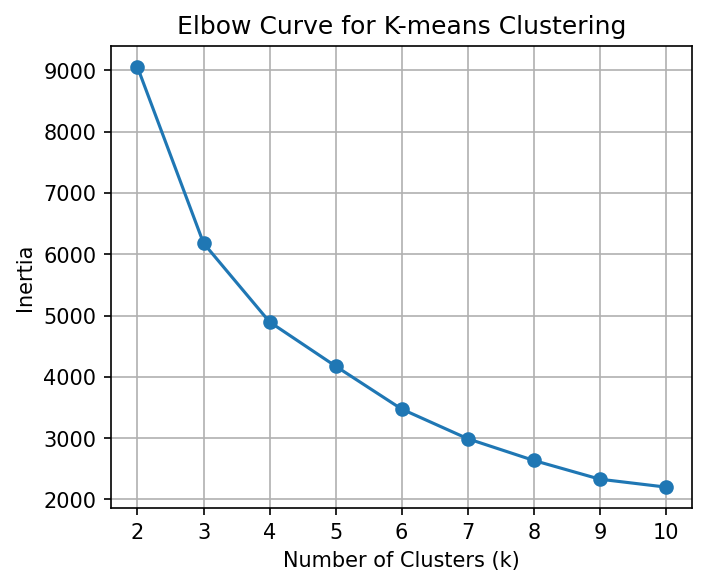

In [47]:
# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init= 10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(5, 4),dpi=150)
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

let’s divide the customer base into four segments.
We’ve fixed K to 4. So let’s run the K-Means algorithm to get the cluster assignments for all points in the dataset:

In [53]:
# Perform K-means clustering with best K
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

# Interpret the Clusters to Identify Customer Segments 

In [56]:
# Group by cluster and calculate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_Score': 'mean',
    'F_Score': 'mean',
    'M_Score': 'mean'
}).reset_index()

In [57]:
cluster_summary

,Cluster,R_Score,F_Score,M_Score
0,0,4.682540,3.188889,3.728571
1,1,1.443678,1.058621,1.497701
2,2,3.883229,1.078370,1.692790
3,3,2.922414,1.991379,3.154095


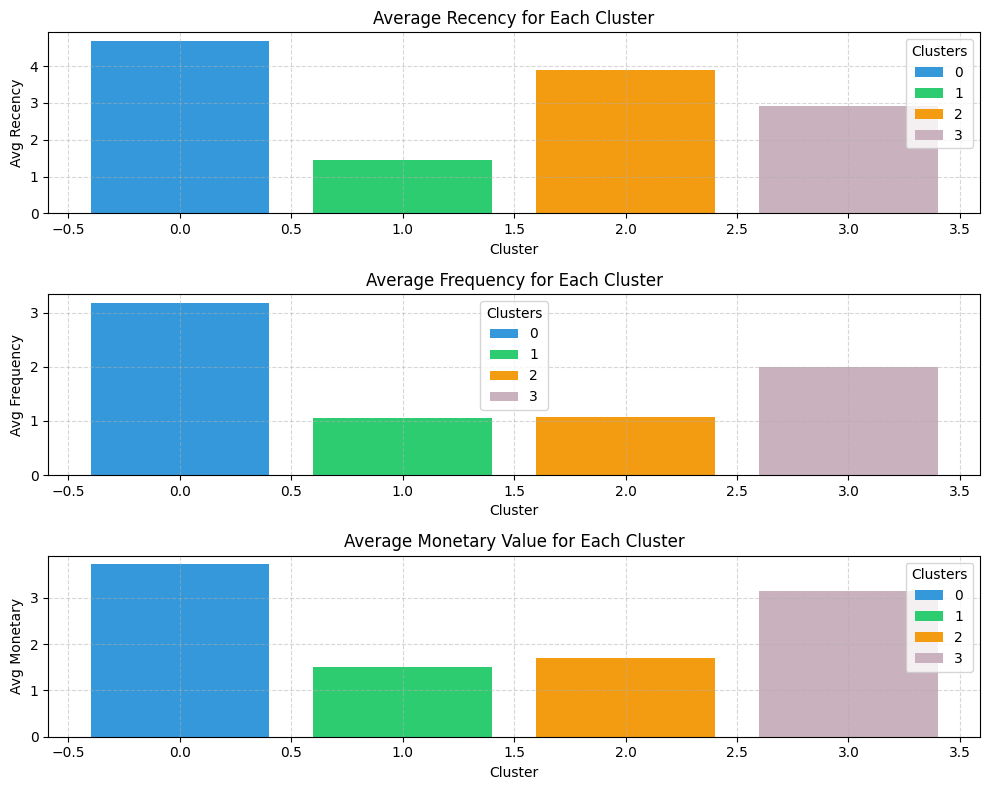

In [55]:
# let's visualise the RFM values 
colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8),dpi=100)

# Plot Avg Recency
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Recency')
plt.title('Average Recency for Each Cluster')

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Frequency')
plt.title('Average Frequency for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Monetary
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_Score'], color=colors)
plt.xlabel('Cluster')
plt.ylabel('Avg Monetary')
plt.title('Average Monetary Value for Each Cluster')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

Cluster 0: Of all the four clusters, this cluster has the highest recency, frequency, and monetary values. Let’s call the customers in this cluster champions.

Cluster 1:  This cluster has low values in Recency,frequency and monetary. so they are at-Risk customers.

Cluster 2:  This cluster is characterized by high recency and relatively lower frequency and moderate monetary values. So these are recent customers who can potentially become long-term customers.

Cluster 3: This cluster is characterized by moderate frequency,recency and monetary values. Let's call them loyal customers.

1. For Champions: Offer personalized special discounts, early access, and other premium perks to make them feel valued and appreciated.

2. For Loyal Customers: Appreciation campaigns, referral bonuses, and rewards for loyalty.

3. For At-Risk Customers: Re-engagement efforts that include running discounts or promotions to encourage buying.

4  For Recent Customers: Targeted campaigns educating them about the brand and discounts on subsequent purchases. 



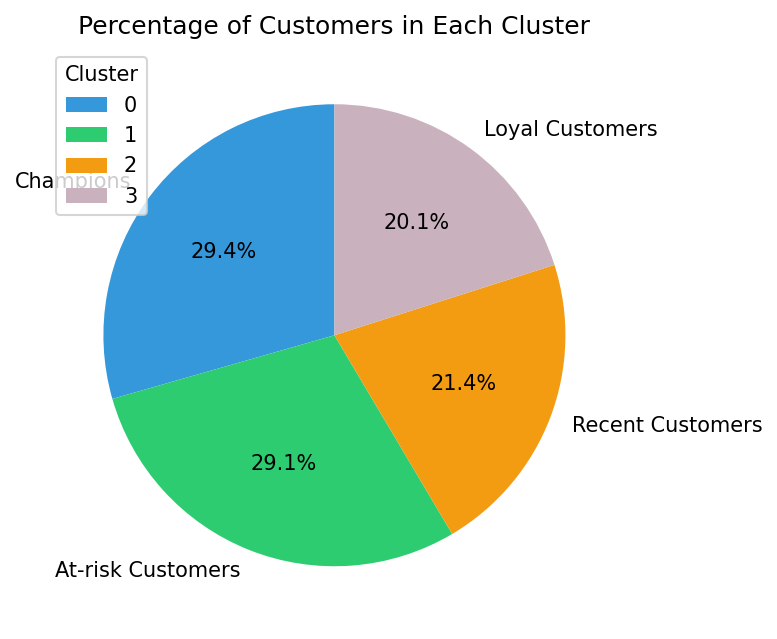

In [60]:
cluster_counts = rfm['Cluster'].value_counts()

colors = ['#3498db', '#2ecc71', '#f39c12','#C9B1BD']
# Calculate the total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
percentage_customers = (cluster_counts / total_customers) * 100

labels = ['Champions','At-risk Customers','Recent Customers','Loyal Customers']

# Create a pie chart
plt.figure(figsize=(5, 5),dpi=150)
plt.pie(percentage_customers, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='Cluster', loc='upper left')

plt.show()